In [39]:
import numpy as np
import matplotlib.pyplot as plt
from generate_magnetic_field import get_mag_field
import torch.nn as nn
import torch

In [40]:
# genrate coordinate mesh 
x_data_points = 11
x_array = np.linspace(-1,1,x_data_points)
x_array
xv,yv,zv = np.meshgrid(x_array,x_array,x_array,indexing='ij')

In [41]:
# create BV mask 
xyv_mask    = ((xv==-1) + (xv==0) + (xv==1)) * ((yv==-1) + (yv==0) + (yv==1))
zv_mask     = (zv==-1) + (zv ==1) + (zv==0)
center_mask = (xv==0)*(yv==0)*(zv==0)
bv_mask     = (xyv_mask) * (zv_mask)* (~center_mask)

In [42]:
# calculate B(B_x,B_y,B_z) field at x,y,z meshgrid 
B = get_mag_field(2,xv,yv,zv)       # get B at x,y,z mesh 
B = B.reshape(*xv.shape,3)          # reshape B to have shape as coordinate mesh 
Bv = B[bv_mask]                     # get the BV (26 values)
B[~bv_mask] = 0                     # set phyics BV =0 

In [43]:
# bv coordinates 
Bv_coords = np.array([xv[bv_mask],yv[bv_mask],zv[bv_mask]]).T
Bv_coords = torch.from_numpy(Bv_coords).type(torch.float32)      # convert to torch.tensor

In [44]:
# physics BV coords 
PBv_coords = np.array([xv[~bv_mask],yv[~bv_mask],zv[~bv_mask]]).T
PBv_coords = torch.from_numpy(PBv_coords).type(torch.float32).requires_grad_(True)     # convert to torch.tensor
PBv_coords

tensor([[-1.0000, -1.0000, -0.8000],
        [-1.0000, -1.0000, -0.6000],
        [-1.0000, -1.0000, -0.4000],
        ...,
        [ 1.0000,  1.0000,  0.4000],
        [ 1.0000,  1.0000,  0.6000],
        [ 1.0000,  1.0000,  0.8000]], requires_grad=True)

In [45]:
# Bvs (magentic field at boundaries)
Bv = torch.from_numpy(Bv).type(torch.float32)

In [46]:
Bv

tensor([[-4.3300e-02, -2.3550e-02,  9.5380e-01],
        [-2.5400e-02,  1.2450e-02,  9.2760e-01],
        [ 7.1000e-03,  5.9650e-02,  9.0820e-01],
        [-5.0175e-02, -1.9900e-02,  9.7690e-01],
        [-2.3275e-02,  1.5000e-03,  9.6190e-01],
        [ 1.8225e-02,  3.4100e-02,  9.5370e-01],
        [-6.4100e-02, -2.9250e-02,  9.8540e-01],
        [-2.8200e-02, -2.2450e-02,  9.8160e-01],
        [ 2.2300e-02, -4.4500e-03,  9.8460e-01],
        [-2.7625e-02, -2.6000e-02,  9.6830e-01],
        [-1.9250e-03,  1.9000e-02,  9.5670e-01],
        [ 3.8375e-02,  7.5200e-02,  9.5190e-01],
        [-3.2700e-02, -2.9400e-02,  1.0004e+00],
        [ 5.1300e-02,  4.2600e-02,  1.0064e+00],
        [-4.4825e-02, -4.5800e-02,  1.0179e+00],
        [-1.1250e-03, -3.0000e-02,  1.0287e+00],
        [ 5.7175e-02, -3.0000e-03,  1.0463e+00],
        [-1.9500e-02, -2.6650e-02,  9.9060e-01],
        [ 1.4000e-02,  2.7350e-02,  9.9360e-01],
        [ 6.2100e-02,  9.2550e-02,  1.0034e+00],
        [-2.2775e-02

In [47]:
class FFNN(nn.Module):
    def __init__(self,input_features,output_features,hidden_feature):
        super().__init__()
        self.layer_1 = nn.Linear(input_features,hidden_feature)
        self.layer_2 = nn.Linear(hidden_feature,hidden_feature)
        self.layer_3 = nn.Linear(hidden_feature,hidden_feature)
        self.layer_4 = nn.Linear(hidden_feature,output_features)
        self.activation = nn.Tanh()
        
    def forward(self,x):
        x = self.activation(self.layer_1(x))
        x = self.activation(self.layer_2(x))
        x = self.activation(self.layer_3(x))
        x = self.layer_4(x)
        return x 
        

In [48]:
model = FFNN(3,3,12)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [49]:
epochs = 1000

for epoch in range(epochs):
    model.train()
    B_pred = model(Bv_coords)
    loss = loss_fn(B_pred,Bv)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%100 ==0:
        print(f'epoch:{epoch} | train loss:{loss:.3f}')
    

epoch:0 | train loss:0.245
epoch:100 | train loss:0.001
epoch:200 | train loss:0.000
epoch:300 | train loss:0.000
epoch:400 | train loss:0.000
epoch:500 | train loss:0.000
epoch:600 | train loss:0.000


epoch:700 | train loss:0.000
epoch:800 | train loss:0.000
epoch:900 | train loss:0.000


In [50]:
Bh = model(Bv_coords)
Bh = Bh.detach().numpy()

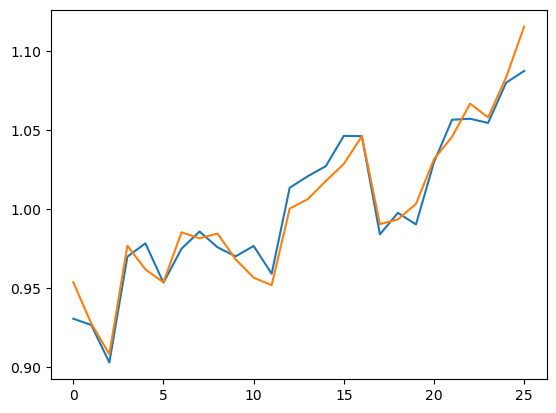

In [51]:
plt.plot(np.arange(len(Bh)),Bh[:,2])
plt.plot(np.arange(len(Bh)),Bv[:,2])

In [52]:
Bhp = model(PBv_coords)
Bhp

tensor([[-4.8342e-02, -9.3524e-03,  9.3221e-01],
        [-4.3016e-02,  6.9961e-05,  9.3252e-01],
        [-3.7173e-02,  9.5728e-03,  9.3163e-01],
        ...,
        [ 4.6704e-02, -1.1846e-02,  1.0858e+00],
        [ 5.7560e-02, -5.8051e-03,  1.0874e+00],
        [ 6.7801e-02,  6.1677e-04,  1.0880e+00]], grad_fn=<AddmmBackward0>)

In [53]:
torch.autograd.grad(Bhp,PBv_coords,torch.ones_like(Bhp))[0].shape

torch.Size([1305, 3])

In [54]:
Bhp.shape

torch.Size([1305, 3])

In [56]:
batch_size = 10
hidden_dim = 20
input_dim = 3
output_dim = 2 

model = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.Tanh(), nn.Linear(hidden_dim, output_dim)).double()
x = torch.rand(batch_size, input_dim, requires_grad=True, dtype=torch.float64) #(batch_size, input_dim)
y = model(x) #y: (batch_size, output_dim) 

#using torch.autograd.grad
dydx1 = torch.autograd.grad(y, x, retain_graph=True, grad_outputs=torch.ones_like(y))[0]  #dydx1: (batch_size, input_dim)
print(f' using grad dydx1: {dydx1.shape}')

#using torch.autograd.functional.jacobian
j = torch.autograd.functional.jacobian(lambda t: model(t), x) #j: (batch_size, output_dim, batch_size, input_dim)

#the off-diagonal elements of 0th and 2nd dimension are all zero. So we remove them
dydx2 = torch.diagonal(j, offset=0, dim1=0, dim2=2) #dydx2: (output_dim, input_dim, batch_size)
dydx2 = dydx2.permute(2, 0, 1) #dydx2: (batch_size, output_dim, input_dim)
print(f' using jacobian dydx2: {dydx2.shape}')

#round to 14 decimal digits to avoid noise 
print(np.round((dydx2.sum(dim=1)).numpy(), 14) == np.round(dydx1.numpy(), 14))

 using grad dydx1: torch.Size([10, 3])
 using jacobian dydx2: torch.Size([10, 2, 3])
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [False  True  True]
 [ True  True  True]
 [ True  True  True]]
